In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from IPython.display import Image
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn import svm
import xgboost as xgb

In [2]:
!nvidia-smi

Fri Oct  8 07:17:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [56]:
path = 'drive/MyDrive/Colab Notebooks/data'
X = pd.read_csv(os.path.join(path,'X_train.csv'))
Y = pd.read_csv(os.path.join(path,'y_train.csv'))
x_test = pd.read_csv(os.path.join(path,'X_test.csv'))

display(X.head(10))

#From Y, we know this is binary classify problem
print(np.unique(Y))

X = X[['SHOT_DIST', 'TOUCH_TIME','CLOSE_DEF_DIST']]
display(X.head(10))
X = X.to_numpy()
Y = Y.to_numpy()

,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST
0,1,358,2.4,0,3.2,20.6,2,4.5
1,1,585,8.3,0,1.2,3.0,2,0.5
2,1,540,19.9,0,0.6,3.5,2,3.2
3,1,392,9.0,0,0.9,21.1,2,4.9
4,3,401,22.7,0,0.7,4.1,2,2.9
5,3,558,18.9,3,2.9,4.1,2,3.3
6,3,181,18.7,0,1.2,0.7,2,1.2
7,1,300,17.1,8,7.5,13.8,2,4.3
8,1,589,12.6,0,0.8,22.5,3,6.1
9,1,252,12.1,0,0.9,22.9,3,13.5


[0 1]


,SHOT_DIST,TOUCH_TIME,CLOSE_DEF_DIST
0,20.6,3.2,4.5
1,3.0,1.2,0.5
2,3.5,0.6,3.2
3,21.1,0.9,4.9
4,4.1,0.7,2.9
5,4.1,2.9,3.3
6,0.7,1.2,1.2
7,13.8,7.5,4.3
8,22.5,0.8,6.1
9,22.9,0.9,13.5


In [67]:
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)
y_train = y_train.reshape(-1)
y_valid = y_valid.reshape(-1)

#Standardization
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_valid_std = sc.fit_transform(x_valid)

svc = svm.SVC(kernel='poly', degree=3)x_valid.shape()
svc.fit(x_train_std, y_train)

y_train_pred = svc.predict(x_train_std)
y_valid_pred = svc.predict(x_valid_std)

print('MSE train: %.2f, valid: %.2f ' % (
                mean_squared_error(y_train, y_train_pred),
                mean_squared_error(y_valid, y_valid_pred)))

print('Acc train: %.2f, valid: %.2f ' % (
                accuracy_score(y_train, y_train_pred),
                accuracy_score(y_valid, y_valid_pred)))

MSE train: 0.39, valid: 0.39 
Acc train: 0.61, valid: 0.61 


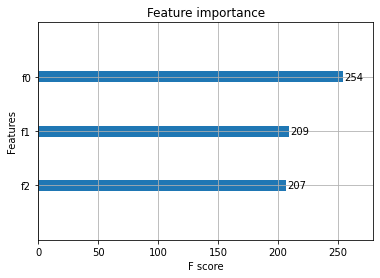

In [68]:
parameters = {'eval_metric':'error', 
              'max_depth':'5', 
              'colsample_bytree':'0.5',
              'subsample':'0.80',
              'gpu_id':'0',
              'tree_method':'gpu_hist'
             }

XGB = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=50)
model = XGB.fit(x_train_std, y_train)
# print(model)
xgb.plot_importance(model)
# model.get_xgb_params()

In [69]:
y_train_pred = model.predict(x_train_std)
y_valid_pred = model.predict(x_valid_std)

print('MSE train: %.2f, valid: %.2f ' % (
                mean_squared_error(y_train, y_train_pred),
                mean_squared_error(y_valid, y_valid_pred)))

print('Acc train: %.2f, valid: %.2f ' % (
                accuracy_score(y_train, y_train_pred),
                accuracy_score(y_valid, y_valid_pred)))

MSE train: 0.38, valid: 0.39 
Acc train: 0.62, valid: 0.61 
